In [1]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
#need to find a way to sample the larger part of the trajectory at a different frequency...

#because currently the amount of knot points is huge...

In [3]:
#From RoadsMPC slide deck
#values are in m and degrees 
#orbits elements of und roads 1
#last is the true anomaly 
elements1 = [6885.635e3, 0.001089, 97.43, 0, 0, 0]

#orbital elements of und roads 2
#last is the true anomaly
elements2 = [6885.635e3, 0.001089, 97.43, 0, 0, 0.016667]

6-element Vector{Float64}:
  6.885635e6
  0.001089
 97.43
  0.0
  0.0
  0.016667

In [4]:
#convert the true anomaly to mean anomaly to be able to do the conversion and degrees to radians

In [5]:
function degrees_to_rad(x)

    return x*pi/180
    
end

degrees_to_rad (generic function with 1 method)

In [6]:
#v is true anomaly 
#e is the eccentricity
function true_anom_to_eccentric_anom(v, e)

    E = 2*atand(sqrt((1-e)/(1+e))*tand(v/2))

    #eccentric anomaly
    return E

end

true_anom_to_eccentric_anom (generic function with 1 method)

In [7]:
function eccentric_anom_to_mean_anom(E, e)

    M = E - e*sind(E)

    #mean anomaly
    return M

end

eccentric_anom_to_mean_anom (generic function with 1 method)

In [8]:
#eccentric anomaly sat 1
E1 = true_anom_to_eccentric_anom(elements1[end], elements1[2])

#mean anomaly sat 1
M1 = eccentric_anom_to_mean_anom(E1, elements1[2])

0.0

In [9]:
#eccentric anomaly sat 2
E2 = true_anom_to_eccentric_anom(elements2[end], elements2[2])

#eccentric anomaly sat 2
M2  = eccentric_anom_to_mean_anom(E2, elements2[2])

0.016648543070573774

In [10]:
#get all the units consistent (m, radians)

elements1_m = [elements1[1:2]; degrees_to_rad(elements1[3]); degrees_to_rad(elements1[4]); degrees_to_rad(elements1[5]); degrees_to_rad(M1)]

elements2_m = [elements2[1:2]; degrees_to_rad(elements2[3]); degrees_to_rad(elements2[4]); degrees_to_rad(elements2[5]); degrees_to_rad(M2)]

6-element Vector{Float64}:
 6.885635e6
 0.001089
 1.7004742902180754
 0.0
 0.0
 0.00029057189224159907

In [11]:
#state satellite 1 (target)

x_1 = sOSCtoCART(elements1_m, use_degrees=false)

6-element Vector{Float64}:
    6.878136543485e6
    0.0
    0.0
    0.0
 -984.9589353739226
 7552.79897887146

In [12]:
#state satellite 2 (chaser)

x_2 = sOSCtoCART(elements2_m, use_degrees=false)

6-element Vector{Float64}:
    6.878136252166805e6
 -259.0113696278884
 1986.134383662354
   -2.2156282462577286
 -984.9588936567426
 7552.798658978454

In [13]:
#relative state of chaser wrt target
#this is in ECI frame
difference = x_2 - x_1 

6-element Vector{Float64}:
   -0.2913181949406862
 -259.0113696278884
 1986.134383662354
   -2.2156282462577286
    4.171718001089175e-5
   -0.0003198930062353611

In [14]:
#this is in the RTN frame of the target (primary observing satellite) 
initial_difference = sECItoRTN(x_1, x_2) 

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [15]:
#unit scaling to make the numerics better (no overshoot)
position_scale = 100
time_scale = 1000

velocity_scale = position_scale/time_scale
acceleration_scale = position_scale/(time_scale)^2

0.0001

In [16]:
#mu - gravitational parameter (m3/s2)
mu = 3.986e14

3.986e14

In [17]:
mu_scaled = mu/(position_scale^3/time_scale^2)

3.986e14

In [18]:
#target orbit period in seconds
T = 2*pi*sqrt((elements1[1]^3)/(mu))

5686.266596687438

In [19]:
#semi major axis of target satellite (meters)
a = elements1[1]

6.885635e6

In [20]:
#scaled semi major axis
a_scaled = a/position_scale

68856.35

In [21]:
#constant mean motion of target n = sqrt(mu/a^3)
#units: rad/s
n = sqrt(mu/a^3)

0.0011049755055170796

In [22]:
n_scaled = sqrt(mu_scaled/a_scaled^3)

1.1049755055170793

In [23]:
#number of states
nx = 6

#number of control inputs
nu = 3

3

In [24]:
#timestep for first 120 steps
dt_120 = 1

1

In [25]:
dt_120_scaled = dt_120/time_scale 

0.001

In [26]:
dt_92 = 60

60

In [27]:
dt_92_scaled = dt_92/time_scale

0.06

In [28]:
#when sampling at 1 second
#N = 94*60+1

In [29]:
# #this is a 5 orbits for dt=60

# #one orbit 
N_120 = 181
N_92 = 91

total_N = N_120 + N_92

# total_N = 212
# #2 orbit look ahead? 
# #N = 188

272

In [30]:
x0_target = zeros(nx) 

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [31]:
#this is in RTN frame
# m and s
x0_chaser = initial_difference

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [32]:
A = zeros(nx, nx)
A[1:3, 4:6] = I(3)
A[4, 1] = 3*n^2
A[6, 3] = -n^2
A[4, 5] = 2*n
A[5, 4] = -2*n

-0.002209951011034159

In [33]:
A_scaled = zeros(nx, nx)
A_scaled[1:3, 4:6] = I(3)
A_scaled[4, 1] = 3*n_scaled^2
A_scaled[6, 3] = -n_scaled^2
A_scaled[4, 5] = 2*n_scaled
A_scaled[5, 4] = -2*n_scaled

-2.2099510110341587

In [34]:
#mass of the satellite (kg) from data
m = 5.22

5.22

In [35]:
#in m/s2. L1 norm 
umax = 4.6e-3

0.0046

In [36]:
umax_scaled = umax/acceleration_scale 

46.0

In [37]:
#si units
B = [zeros(3,3); I(3)]

6×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [38]:
#continous dynamics
function spacecraft_dynamics(x,u)

    xdot = A*x + B*u

    return xdot

end

spacecraft_dynamics (generic function with 1 method)

In [39]:
dt_120_scaled 

0.001

In [40]:
dt_92_scaled

0.06

In [41]:
#discretize the dynamics model 
#for 1 Hz
H_scaled_120 = exp(dt_120_scaled*[A_scaled B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.0         0.0   0.0         …   5.0e-7       3.68325e-10  0.0
 -1.34914e-9  1.0   0.0            -3.68325e-10  5.0e-7       0.0
  0.0         0.0   0.999999        0.0          0.0          5.0e-7
  0.00366291  0.0   0.0             0.001        1.10498e-6   0.0
 -4.04743e-6  0.0   0.0            -1.10498e-6   0.000999999  0.0
  0.0         0.0  -0.00122097  …   0.0          0.0          0.001
  0.0         0.0   0.0             1.0          0.0          0.0
  0.0         0.0   0.0             0.0          1.0          0.0
  0.0         0.0   0.0             0.0          0.0          1.0

In [42]:
#discretize the dynamics model 
#for dt=60 s ~ 0.017 Hz
H_scaled_92 = exp(dt_92_scaled*[A_scaled B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.00659      0.0   0.0        …   0.00179934  7.95408e-5  0.0
 -0.000291351  1.0   0.0           -7.95408e-5  0.00179736  0.0
  0.0          0.0   0.997803       0.0         0.0         0.00179934
  0.219614     0.0   0.0            0.0599561   0.00397645  0.0
 -0.0145654    0.0   0.0           -0.00397645  0.0598242   0.0
  0.0          0.0  -0.0732046  …   0.0         0.0         0.0599561
  0.0          0.0   0.0            1.0         0.0         0.0
  0.0          0.0   0.0            0.0         1.0         0.0
  0.0          0.0   0.0            0.0         0.0         1.0

In [43]:
#Scaled Discrete Dynamics Matrices for dt = 1 s
Ad_scaled_120  = H_scaled_120[1:nx, 1:nx]
Bd_scaled_120 = H_scaled_120[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
  5.0e-7       3.68325e-10  0.0
 -3.68325e-10  5.0e-7       0.0
  0.0          0.0          5.0e-7
  0.001        1.10498e-6   0.0
 -1.10498e-6   0.000999999  0.0
  0.0          0.0          0.001

In [44]:
#Scaled Discrete Dynamics Matrices for dt= 60 s
Ad_scaled_92 = H_scaled_92[1:nx, 1:nx]
Bd_scaled_92 = H_scaled_92[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
  0.00179934  7.95408e-5  0.0
 -7.95408e-5  0.00179736  0.0
  0.0         0.0         0.00179934
  0.0599561   0.00397645  0.0
 -0.00397645  0.0598242   0.0
  0.0         0.0         0.0599561

In [45]:
function spacecraft_dynamics_discrete_scaled(x_scaled, u_scaled, Ad_scaled, Bd_scaled)

    xnext_scaled = Ad_scaled*x_scaled + Bd_scaled*u_scaled

    return xnext_scaled

end

spacecraft_dynamics_discrete_scaled (generic function with 1 method)

In [46]:
#simulate for 1 minute


#x scaled will be a vector

#u scaled will be a control trajectory (3x60)


function sim_one_min(x_scaled, u_traj, Ad_scaled_120, Bd_scaled_120)

    all_x = zeros(6, 61)
    all_x[:,1] = x_scaled

    for i=1:size(u_traj)[2]

        all_x[:,i+1] = spacecraft_dynamics_discrete_scaled(all_x[:,i], u_traj[:,i], Ad_scaled_120, Bd_scaled_120)

    end

    xnext = all_x[:,end]

    return xnext

end

sim_one_min (generic function with 1 method)

In [47]:
x_initial = x0_chaser

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [48]:
x_initial_scaled = [x0_chaser[1:3]/position_scale; x0_chaser[4:6]/velocity_scale] 

6-element Vector{Float64}:
 -0.002913181949406862
 20.029519913273894
  2.701751407263217e-16
  0.02412819262479271
 -1.5962127995240716e-11
  3.511794450825904e-13

In [49]:
x_goal = x0_target

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [50]:
C = zeros(N_120-1-59, N_120-1)

121×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [51]:
for i=1:size(C)[1]

    C[i, i:i+59] = ones(60)
    
end

In [52]:
C

121×180 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [53]:
function update_prob(x_initial_k, C_k)


    X = Convex.Variable(nx, total_N)
    U = Convex.Variable(nu, total_N-1)
    
    #Initial State Constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #Dynamics Constraint
    # for k=1:(N-1)

    #     push!(cons, X[:,k+1] - (Ad_scaled_120*X[:,k] + Bd_scaled_120*U[:,k]) == zeros(6))

    # end



    #for the first 2 minutes sampled at 1 Hz
    for k=1:N_120-1

        push!(cons, X[:,k+1] - (Ad_scaled_120*X[:,k] + Bd_scaled_120*U[:,k]) == zeros(6))

    end

    #for the remaining of the trajectory 
    for k=N_120:total_N - 1

        push!(cons, X[:,k+1] - (Ad_scaled_92*X[:,k] + Bd_scaled_92*U[:,k]) == zeros(6))

    end


    # for k=1:60

    #     push!(cons, sum(U[:,k:k+59]) <= umax/acceleration_scale)
        
    # end


    
    #control constraint for first 2 minutes
    push!(cons, C_k*([1 1 1]*abs(U[:, 1:N_120-1]))' <= umax/acceleration_scale*ones(size(C)[1]))


    #add in thrust constraints

    #try both l1 and l2

    # for k=N_2_min:N_2_min + N_92_min - 1

    #    #L2 thrust constraint
    #    #push!(cons, norm(U[:,k],2) <= umax/acceleration_scale)

    # #    #L1 thrust constraint
    # #works when bound is 1

    #push!(cons, norm(U[:,k],1) <= (umax/60/acceleration_scale))

    # #push!(cons, U[:,k] == zeros(3))

    # end

    #control constraint (testing)
    for k=N_120:(total_N-1)

       push!(cons, norm(U[:,k], 1) <= umax/60/acceleration_scale)
       

    end


    #slow progress... (kinda working?)
    #the constraint with C gives a similar solution, however, it is faster 
    # for k=1:(N-1)-59

    #     #slow progress
    #     push!(cons, sum(abs(U[:,k:k+59])) <= umax/acceleration_scale)

    # end




    
    #not working
    # for k=1:N-1-59

    #     normz_60 = 0

    #     for j = k:k+59

    #         normz_60 += norm(U[:,j], 1) 

    #     end

    #     push!(cons, normz_60 <= umax/acceleration_scale)

    # end
    

    return cons, X, U

end

update_prob (generic function with 1 method)

In [54]:
function solve_prob(cons, X, U, N)


    #objective 
    obj = 0

    #weights depending how conservative you want to be on fuel vs reaching the goal
    #sensative to these weights. with beta as 100 it wouldn't solve...

    #these weights do something (need tuning)
    # beta_120 = 0.1
    # alpha_120 = 100

    # beta_92 = 100
    # alpha_92 = 1
    # alpha_92_end = 1000

    #works kinda (converges to zero kinda)
    # beta_120 = 0.1
    # alpha_120 = 1

    # beta_92 = 100
    # alpha_92 = 1
    # alpha_92_end = 1


    #these work the best
    beta_120 = 0.1
    alpha_120 = 1

    beta_92 = 1
    alpha_92 = 100
    alpha_92_end = 100


    

    #testing (not working)
    # beta_120 = 1
    # alpha_120 = 1

    # beta_92 = 1000
    # alpha_92 = 1
    # alpha_92_end = 1

    #trying old weights (the satellite finds it optimal to just do nothing...)
    # beta_120 = 1
    # alpha_120 = 1

    # beta_92 = 1
    # alpha_92 = 1
    # alpha_92_end = 1

    #Initial 2 minute trajectory
    for k=1:N_120-1

        obj += beta_120*norm(U[:,k], 1) + alpha_120*norm(X[:,k], 2)

    end

    #Rest of the trajectory
    for k=N_120:total_N - 1

        obj += beta_92*norm(U[:,k], 1) + alpha_92*norm(X[:,k], 2)

    end

    #terminal cost
    obj += alpha_92_end*norm(X[:,N], 2)



    #working previous cost (all trajectory)
    # for k=1:total_N-1
    #     #trying L2 cost on controls (doesn't work, all zeros)
        
    #     #L1 gets a solution but it is not completely correct...
    #     obj += beta*norm(U[:,k], 1) + alpha*norm(X[:,k], 2)

    # end

    # #terminal cost
    # obj += alpha*norm(X[:,total_N], 2)

    prob = minimize(obj, cons)

    #solve with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=true);

    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver = true)

    Xm = X.value
    Um = U.value

    return Xm, Um

end

solve_prob (generic function with 1 method)

In [55]:
#iterations = 1000
num_orbits = 3

#iterations = N*num_orbits/60

iterations = 400

400

In [56]:
#set up in Convex.jl

In [57]:
xhist = zeros(nx, iterations)
uhist = zeros(nu, (iterations-1)*60)

xhist[:,1] = x_initial_scaled

6-element Vector{Float64}:
 -0.002913181949406862
 20.029519913273894
  2.701751407263217e-16
  0.02412819262479271
 -1.5962127995240716e-11
  3.511794450825904e-13

In [58]:
C_k = C

121×180 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [59]:
for i=1:iterations-1

#for i=1:iterations-1

#for 60 second constraint
#for i in iters_odd 

#took 50 minutes for 10 iterations. output was just zero controls...
#for i=1:10

# i=1

    cons, X, U = update_prob(xhist[:,i], C_k)

    Xm, Um = solve_prob(cons, X, U, total_N)

    #take one step 
    #uhist[:,i] = Um[:,1]

    u_traj = Um[:,1:60]

    uhist[:, (i-1)*60+1: (i-1)*60+60] = Um[:,1:60]

    max_sum = vec(sum(u_traj, dims=1))

    control_index = findmax(max_sum)[2]

    #modify the C to repect the 60 second constraint
    #commenting out this logic 
    if control_index ==1

        C_k = C

    else
        println("changing C...")
        C_k = C
        C_k[1:control_index-1, :] = zeros(control_index-1, N_120-1)

    end

    #uhist[:,i+1] = Um[:,2]

    xhist[:,i+1] = sim_one_min(xhist[:,i], u_traj, Ad_scaled_120, Bd_scaled_120)

    println("Minute: ", i, " done")

    #xhist[:,i+1] = spacecraft_dynamics_discrete_scaled(xhist[:,i], uhist[:,i])

    #xhist[:,i+2] = spacecraft_dynamics_discrete(xhist[:,i+1], uhist[:,i+1])

end

Minute: 1 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 2 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 3 done
Minute: 4 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 5 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 6 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 7 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 8 done
Minute: 9 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 10 done
Minute: 11 done
Minute: 12 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 13 done
Minute: 14 done
Minute: 15 done
Minute: 16 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 17 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 18 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 19 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 20 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 21 done
Minute: 22 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 23 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 24 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 25 done
Minute: 26 done
Minute: 27 done
Minute: 28 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 29 done
Minute: 30 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 31 done
Minute: 32 done
Minute: 33 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 34 done
Minute: 35 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 36 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 37 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 38 done
Minute: 39 done
Minute: 40 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 41 done
Minute: 42 done
Minute: 43 done
Minute: 44 done
Minute: 45 done
Minute: 46 done
Minute: 47 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 48 done
Minute: 49 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 50 done
changing C...
Minute: 51 done
changing C...
Minute: 52 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


changing C...
Minute: 53 done
changing C...
Minute: 54 done
changing C...
Minute: 55 done
changing C...
Minute: 56 done
changing C...
Minute: 57 done
changing C...
Minute: 58 done
changing C...
Minute: 59 done
changing C...
Minute: 60 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


changing C...
Minute: 61 done
changing C...
Minute: 62 done
changing C...
Minute: 63 done
changing C...
Minute: 64 done
changing C...
Minute: 65 done
changing C...
Minute: 66 done
changing C...
Minute: 67 done
changing C...
Minute: 68 done
changing C...
Minute: 69 done
changing C...
Minute: 70 done
changing C...
Minute: 71 done
changing C...
Minute: 72 done
changing C...
Minute: 73 done
changing C...
Minute: 74 done
changing C...
Minute: 75 done
changing C...
Minute: 76 done
changing C...
Minute: 77 done
changing C...
Minute: 78 done
changing C...
Minute: 79 done
changing C...
Minute: 80 done
changing C...
Minute: 81 done
changing C...
Minute: 82 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


changing C...
Minute: 83 done
changing C...
Minute: 84 done
changing C...
Minute: 85 done
changing C...
Minute: 86 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


changing C...
Minute: 87 done
changing C...
Minute: 88 done
changing C...
Minute: 89 done
Minute: 90 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


changing C...
Minute: 91 done
changing C...
Minute: 92 done
Minute: 93 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 94 done
changing C...
Minute: 95 done
changing C...
Minute: 96 done
Minute: 97 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Minute: 98 done
changing C...
Minute: 99 done
Minute: 100 done
changing C...
Minute: 101 done
Minute: 102 done
changing C...
Minute: 103 done
Minute: 104 done
changing C...
Minute: 105 done
changing C...
Minute: 106 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


changing C...
Minute: 107 done


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


changing C...
Minute: 108 done
changing C...
Minute: 109 done
Minute: 110 done
Minute: 111 done
Minute: 112 done
Minute: 113 done
Minute: 114 done
Minute: 115 done
Minute: 116 done
Minute: 117 done
Minute: 118 done
Minute: 119 done
Minute: 120 done
Minute: 121 done
Minute: 122 done
Minute: 123 done
Minute: 124 done
Minute: 125 done
Minute: 126 done
Minute: 127 done
Minute: 128 done
Minute: 129 done
Minute: 130 done
Minute: 131 done
Minute: 132 done
Minute: 133 done
Minute: 134 done
Minute: 135 done
Minute: 136 done
Minute: 137 done
Minute: 138 done
Minute: 139 done
Minute: 140 done
Minute: 141 done
changing C...
Minute: 142 done
Minute: 143 done
changing C...
Minute: 144 done
changing C...
Minute: 145 done
changing C...
Minute: 146 done
changing C...
Minute: 147 done
changing C...
Minute: 148 done
changing C...
Minute: 149 done
changing C...
Minute: 150 done
Minute: 151 done
changing C...
Minute: 152 done
Minute: 153 done
changing C...
Minute: 154 done
Minute: 155 done
changing C...
Mi

In [60]:
C_k 

121×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [61]:
index = 2
C_k_new = C
C_k_new[1:index-1, :] = zeros(180)

180-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [62]:
C_k_new 

121×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [63]:
xhist 

6×400 Matrix{Float64}:
 -0.00291318   -0.00130586    0.000801693  …   2.8218e-9     2.74778e-9
 20.0295       20.0322       20.0373           5.09009e-10   4.8998e-10
  2.70175e-16  -6.86848e-12  -6.26555e-11      1.4047e-9     1.50735e-9
  0.0241282     0.0294797     0.0407968        1.29398e-9   -9.71989e-10
 -1.59621e-11   0.0424479     0.0837903       -4.05665e-10  -2.40007e-10
  3.51179e-13  -1.84938e-10  -1.39693e-9   …   1.78437e-9    1.65536e-9

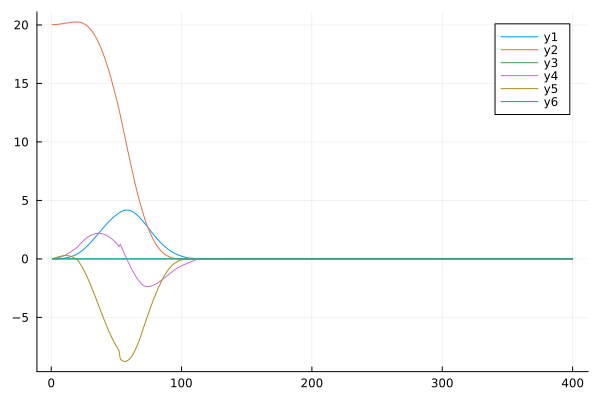

In [64]:
plot(xhist' )

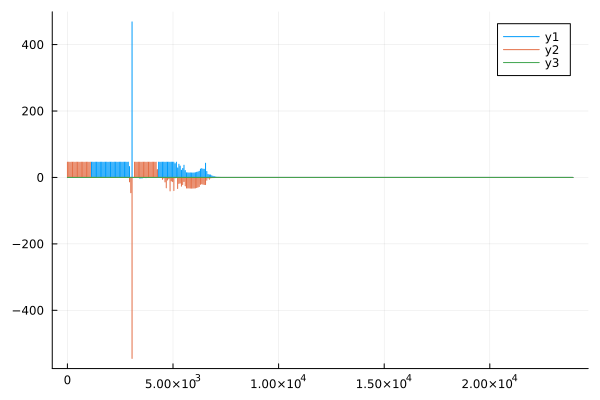

In [65]:
plot(uhist')

In [ ]:
plot(uhist[:,1:360]')

In [ ]:
plot(uhist[:, 1:300]')

In [ ]:
xhist_si = [xhist[1:3, :]*position_scale; xhist[4:6, :]*velocity_scale]  

In [ ]:
#rescale uhist into m/s2

uhist_si = uhist*acceleration_scale 

In [ ]:
max_sum = vec(sum(uhist_si[:,1:60], dims=1))

findmax(max_sum)[2]

In [ ]:
plot(xhist_si[1,:], xhist_si[2,:], xhist_si[3,:], label = "Chaser Trajectory", zlim = (-1,1))

scatter!([xhist_si[1,1]], [xhist_si[2,1]], [xhist_si[3,1]], label = "Initial State")
scatter!([xhist_si[1,end]], [xhist_si[2,end]], [xhist_si[3,end]], label = "End State")

scatter!([0], [0], [0], label= "Target")

In [ ]:
plot(xhist_si[2,:], xhist_si[1,:], xlabel= "Tangential (m)", ylabel="Radial (m)")

In [ ]:
plot(xhist_si[3,:], xhist_si[1,:], xlabel= "Normal (m)", ylabel="Radial (m)", label=false)

In [ ]:
plot(xhist_si[1,:], title="Positions") 
plot!(xhist_si[2,:])
plot!(xhist_si[3,:])

In [ ]:
plot(xhist_si[4,:], title="Velocities") 
plot!(xhist_si[5,:])
plot!(xhist_si[6,:])

In [ ]:
uhist_si 

In [ ]:
uhist_si[:, 1:60]

In [ ]:
plot(uhist_si[2, :])

In [ ]:
plot(uhist_si[1,:], title = "Controls")
plot!(uhist_si[2,:])
plot!(uhist_si[3,:])

In [ ]:
C 

In [ ]:
plot(uhist_si[1,1:2500], title = "Controls", label="u_x", xlabel = "Time (s)", ylabel = "Acceleration (m/s2)")
plot!(uhist_si[2,1:2500], label="u_y")
plot!(uhist_si[3,1:2500], label="u_z")

In [ ]:
plot(uhist_si[1,7000:7500], title = "Controls")
plot!(uhist_si[2,7000:7500])
plot!(uhist_si[3,7000:7500])

In [ ]:
plot(uhist_si[2, 1:360])

In [ ]:
#units: m/s2
fuel_usage_accel = sum(abs.(vec(uhist_si)))

In [ ]:
#these are 1 second impulses
#units: m/s
delta_v = 1*fuel_usage_accel 

In [ ]:
no_control = zeros(nx, iterations)

In [ ]:
no_control[:,1] = x0_chaser

In [ ]:
for i = 1:iterations-1

    no_control[:, i+1] = Ad*no_control[:,i]

end

In [ ]:
# plot(no_control[1,:], no_control[2,:], no_control[3,:], zlims=(-1,1))
# scatter!([0], [0], [0])

In [ ]:
plot(no_control[2,:], no_control[1,:])

In [ ]:
plot(no_control[3,:], no_control[1,:])

In [ ]:
Ad_scaled 